In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from os.path import join as pjoin
import csv
import itertools
import argparse
import time
from tqdm import tqdm
import multiprocessing
from nilearn import datasets
from nilearn import surface

### NSD data preprocessing workflow
1. load 3d data from hdf5
2. frame the visual areas
3. start convolution (2d or 3d)

In [2]:
subj = 'subj02'
pic=11

In [3]:
basedir = f'/Volumes/side_project/nsd/fsaverage/{subj}'

In [4]:
# get the voxel index for each subject
fsaverage_betas = nib.load('/Users/yilewang/Desktop/lh.betas_session01.mgh')
print(fsaverage_betas.get_fdata()[:,0,0,:])

[[-0.6676476  -1.23361218 -2.19000125 ...  1.2338618   0.77526712
  -0.19022603]
 [ 1.73149765  1.11558926  0.67865771 ...  1.44248617  1.14095104
   1.85204315]
 [-0.43909064 -0.21986611 -0.88706809 ...  0.20550986  0.35769048
   0.1540612 ]
 ...
 [-0.98757762  1.18258369  3.04249454 ...  8.27415085  2.73781109
  -7.292871  ]
 [ 0.70728177 -5.3067379  -0.24202187 ... -6.23819733 -6.07387161
   0.16555388]
 [ 2.45138288 -1.82057726  4.81962585 ... -5.25241423 -5.87139893
   4.19888926]]


In [5]:
## get the 3d coordinates of the fsaverage mesh surface
fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage")
left_pial = surface.load_surf_mesh(fsaverage["infl_left"])
right_pial = surface.load_surf_mesh(fsaverage["infl_right"]) 

In [6]:
# import mask
roidir = '/Users/yilewang/Downloads/'+subj
fmri_dir = pjoin(roidir, 'roi_masks')

# load npy file
# lh_visualrois = np.load(pjoin(fmri_dir, 'lh.all-vertices_fsaverage_space.npy'))
# rh_visualrois = np.load(pjoin(fmri_dir, 'rh.all-vertices_fsaverage_space.npy'))

# lh_visualrois = np.load("/Users/yilewang/workspaces/diff_fMRI/roi_masks/lh.prf-visualrois_fsaverage_space.npy")
# rh_visualrois = np.load("/Users/yilewang/workspaces/diff_fMRI/roi_masks/rh.prf-visualrois_fsaverage_space.npy")

lh_visualrois = np.load("/Users/yilewang/workspaces/diff_fMRI/roi_masks/lh.streams_fsaverage_space.npy")
rh_visualrois = np.load("/Users/yilewang/workspaces/diff_fMRI/roi_masks/rh.streams_fsaverage_space.npy")

In [7]:
print(lh_visualrois[np.where(lh_visualrois)[0]].shape)

(18429,)


In [8]:
# apply mask to the whole brain voxels

# Map the fMRI data onto the brain surface map

# get the 3d coordinates of the visual cortex
visual_left_3d = left_pial.coordinates[np.where(lh_visualrois)[0]]
visual_right_3d = right_pial.coordinates[np.where(rh_visualrois)[0]]

print(left_pial.coordinates)

[[ -5.880375    2.4935925  57.6218   ]
 [ 16.480145  -64.23392    54.90657  ]
 [ 30.06189    16.557844   43.14961  ]
 ...
 [ -6.0307627 -10.785628  -61.89195  ]
 [ -6.2678623 -10.915738  -61.9796   ]
 [ -6.4933124 -11.027567  -62.062485 ]]


In [9]:
print(lh_visualrois)

[0 0 0 ... 0 0 0]


In [10]:
%matplotlib widget
from sklearn import datasets, manifold
import matplotlib.pyplot as plt
from matplotlib import ticker
import mpl_toolkits.mplot3d 
n_samples = 1500
# S_points, S_color = datasets.make_s_curve(len(visual_left_3d), random_state=0)
S_color = rh_visualrois[np.where(rh_visualrois)[0]]


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    col = ax.scatter(x, y, c=points_color, s=0.5, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    # add a colorbar to the bottom, with ticks showing all the classes at each boundary
    fig = ax.get_figure()
    fig.colorbar(col, ticks=np.unique(points_color), orientation="horizontal")



def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True, )
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=0.5, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()



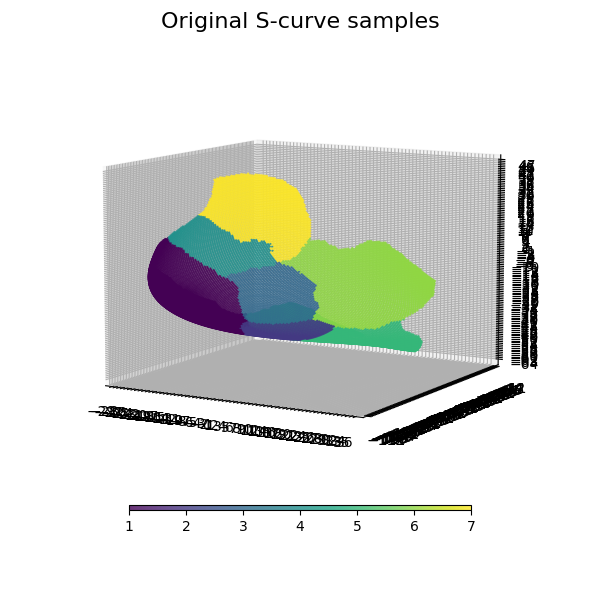

In [11]:
plot_3d(visual_right_3d, S_color, "Original S-curve samples")

In [12]:

n_neighbors = 12
n_components = 2

isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=2)

S_isomap = isomap.fit_transform(visual_right_3d)


2


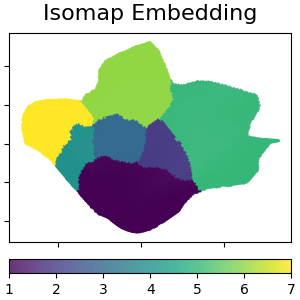

In [13]:
print(n_components)
plot_2d(S_isomap, S_color, "Isomap Embedding")

In [14]:
# get the minimal and maximal value of the 2d S_isomap
# print the difference between min and max

print(S_isomap[:,0].max())
print(S_isomap[:,0].min())

print(S_isomap[:,0].max(), S_isomap[:,0].min())

# print the difference between min and max
print(S_isomap[:,1].max(), S_isomap[:,1].min())

82.51724
-71.66125
82.51724 -71.66125
52.68464 -46.09845


In [15]:
from scipy.interpolate import LinearNDInterpolator
x = S_isomap[:,0]
y = S_isomap[:,1]
x_max, x_min = x.max(), x.min()
y_max, y_min = y.max(), y.min()
X = np.linspace(-80, 80, num=160)
Y = np.linspace(-45, 45, num=90)
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = LinearNDInterpolator(list(zip(x, y)), S_color)

Z = interp(X, Y)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


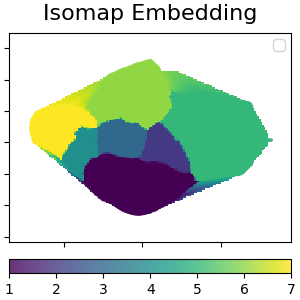

In [16]:
plt.pcolormesh(X, Y, Z, shading='auto')
# plt.plot(x, y, "ok", label="input point")
plt.legend()
# plt.colorbar()
plt.axis("equal")
plt.show()

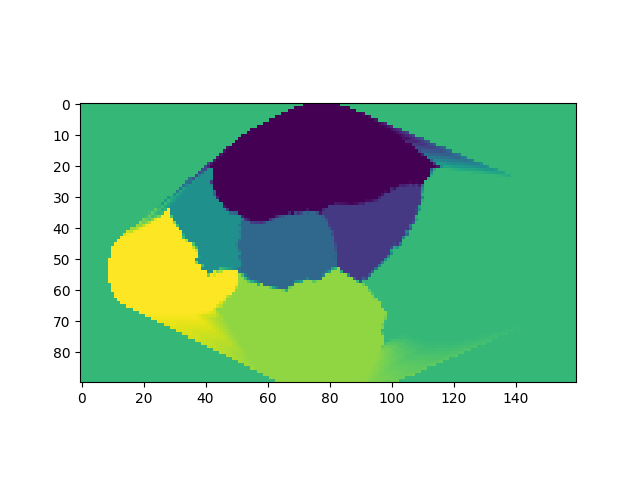

In [17]:
# replace nan to 255 in Z
Z*=51
Z[np.isnan(Z)] = 255
plt.close('all')
plt.imshow(Z)
plt.show()

In [18]:
from PIL import Image
im = Image.fromarray(Z.astype(np.uint8))
im.save("/Users/yilewang/Desktop/2d.png")

No such comm: de43344d1ba242f4af5a2fdc8e8c9e0f


### 2D and 3D convolution

In [19]:
# m = nn.Conv3d(16, 33, 3, stride=2)
# # non-square kernels and unequal stride and with padding
# m = nn.Conv3d(16, 33, (3, 5, 2), stride=(2, 1, 1), padding=(4, 2, 0))
# input = torch.randn(20, 16, 10, 50, 100)
# output = m(input)